In [2]:
import numpy as np
import pandas as pd
from pylab import plt, style
style.use('seaborn-v0_8')

In [3]:
def _tick_rule(price, prev_price):
    bt = 0
    if prev_price is not None: diff = price - prev_price
    if diff != 0 and prev_price is not None: bt = 1 if diff > 0 else -1
    return bt

def _create_ticks_bars(data, threshold=1000):
    ewma_bt, ewma_T = 0, 0
    prev_price = None
    ticks_bar = []
    for i, row in enumerate(data):
        price = row['price']
        size = row['size']
        bt = _tick_rule(price, prev_price)
        prev_price = price
        if bt != 0:
            ewma_bt = 0.7 * ewma_bt + 0.3 * bt
            ewma_T = 0.7 * ewma_T + 0.3 * size
            ticks_bar.append({
                'timestamp': row['timestamp'],
                'price': price,
                'size': size,
                'bt': bt,
                'ewma_bt': ewma_bt,
                'ewma_T': ewma_T
            })
        if i > 0 and (i % threshold == 0 or i == len(data) - 1):
            yield ticks_bar
            ticks_bar = []

In [4]:
# Parameters
num_rows = 1000
price_range = (100, 200)
size_range = (1, 100)

# Generate random data
np.random.seed(42)
timestamps = pd.date_range(start="2025-01-01", periods=num_rows, freq="T")
prices = np.random.uniform(low=price_range[0], high=price_range[1], size=num_rows)
sizes = np.random.randint(low=size_range[0], high=size_range[1], size=num_rows)

# Create DataFrame
tick_data = pd.DataFrame({
    'timestamp': timestamps,
    'price': prices,
    'size': sizes
})

# Save to CSV
tick_data.to_csv('tick_data.csv', index=False)


C:\Users\praty\AppData\Local\Temp\ipykernel_14084\4198591351.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(start="2025-01-01", periods=num_rows, freq="T")


In [5]:
tick_data.head()

,timestamp,price,size
0,2025-01-01 00:00:00,137.454012,47
1,2025-01-01 00:01:00,195.071431,12
2,2025-01-01 00:02:00,173.199394,62
3,2025-01-01 00:03:00,159.865848,80
4,2025-01-01 00:04:00,115.601864,88


In [6]:
###
def generate_tickbars(df: pd.DataFrame, threshold: int = 10):
    new_data = []

    for i in range(0, len(df), threshold):
        chunk = df.iloc[i:i+threshold]
        open_ = chunk['price'].iloc[0]
        close = chunk['price'].iloc[-1]
        high = chunk['price'].max()
        low = chunk['price'].min()
        volume = chunk['size'].sum()
        timestamp = chunk['timestamp'].iloc[-1]
        new_data.append([timestamp, open_, high, low, close, volume])

    return new_data

In [7]:
new_data = generate_tickbars(tick_data, threshold=10)

In [8]:
# Assuming new_data is the output from your tick bar function
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
tickbars_df = pd.DataFrame(new_data, columns=columns)

# Optional: set timestamp as index
tickbars_df['timestamp'] = pd.to_datetime(tickbars_df['timestamp'])
tickbars_df.set_index('timestamp', inplace=True)

# Display first few rows
print(tickbars_df.head())

                           open        high         low       close  volume
timestamp                                                                  
2025-01-01 00:09:00  137.454012  195.071431  105.808361  170.807258     577
2025-01-01 00:19:00  102.058449  196.990985  102.058449  129.122914     591
2025-01-01 00:29:00  161.185289  178.517596  104.645041  104.645041     294
2025-01-01 00:39:00  160.754485  196.563203  106.505159  144.015249     466
2025-01-01 00:49:00  112.203823  190.932040  103.438852  118.485446     683


In [9]:
###
def generate_volumebars(data: pd.DataFrame, threshold: int = 10):
    new_data = []
    open_, high, low, close, volume = np.nan, -np.inf, np.inf, np.nan, 0.0

    for _, row in data.iterrows():
        price, size, timestamp = row['price'], row['size'], row['timestamp']

        if np.isnan(open_):
            open_ = price
        high = max(high, price)
        low = min(low, price)
        volume += size

        # Create bar when volume threshold reached
        if volume >= threshold:
            close = price
            new_data.append([timestamp, open_, high, low, close, volume])
            open_, high, low, close, volume = np.nan, -np.inf, np.inf, np.nan, 0.0

    # Append last partial bar if any
    if not np.isnan(open_):
        timestamp = data['timestamp'].iloc[-1]
        new_data.append([timestamp, open_, high, low, close, volume])

    # Convert to DataFrame
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    return pd.DataFrame(new_data, columns=columns)

In [10]:
volumne_bars = generate_volumebars(tick_data, threshold=200)

volumne_bars.tail()

,timestamp,open,high,low,close,volume
208,2025-01-01 16:21:00,159.684285,177.091220,133.424389,177.091220,220.0
209,2025-01-01 16:28:00,110.659825,172.818876,107.513778,124.640203,267.0
210,2025-01-01 16:31:00,181.910232,181.910232,169.469647,169.469647,201.0
211,2025-01-01 16:35:00,127.214514,159.023067,109.158207,109.158207,244.0
212,2025-01-01 16:39:00,191.731358,195.023735,113.681863,NaN,113.0


In [11]:
###
def etf(args):
    o, p, d, phi, omega, B = args
    N, T = o.shape
    delta, K, h = np.zeros((N, T)), np.zeros(T), np.zeros((N, T))
    K[0] = 1.0
    # initial rebalance if 0 in B: create holdings at t=0 using K[0] and o[:,1]
    if 0 in B and T>1:
        denom = np.sum(np.abs(omega[:,0]))
        h[:,0] = (omega[:,0] * K[0]) / (o[:,1] * phi[:,0] * (denom if denom!=0 else 1.0))
    for t in range(1, T):
        if (t-1) in B:
            delta[:, t] = p[:, t] - o[:, t]
        else:
            delta[:, t] = p[:, t] - p[:, t-1]
        K[t] = K[t-1] + np.sum(h[:, t-1] * phi[:, t] * (delta[:, t] + d[:, t]))
        if t in B and t < T-1:
            denom = np.sum(np.abs(omega[:,t]))
            denom = denom if denom!=0 else 1.0
            h[:, t] = (omega[:, t] * K[t]) / (o[:, t+1] * phi[:, t] * denom)
        else:
            h[:, t] = h[:, t-1]
    return K, h, delta

In [12]:
# ---- Synthetic test ----
np.random.seed(42)
N, T = 2, 1000
o = 100 + np.cumsum(np.random.randn(N, T), axis=1)
p = o + np.random.randn(N, T) * 0.5
d = np.random.normal(0.0, 0.0, (N, T))
phi = np.ones((N, T))
omega = np.array([[0.5]*T,
                  [0.5]*T])
B = [0, 3, 6]

K, h, delta = etf((o, p, d, phi, omega, B))

print("ETF Value Series (K):", np.round(K, 4))
print("\nHoldings at last bar (h):\n", np.round(h[:, -1], 6))
print("\nPrice deltas (delta):\n", np.round(delta, 3))

ETF Value Series (K): [1.     0.9975 1.0005 1.0118 1.0085 1.0098 1.026  1.0202 1.0331 1.03
 1.0289 1.0332 1.0381 1.0246 1.031  1.0307 1.0161 1.0078 1.0141 1.0071
 1.0216 1.0141 1.0171 1.018  1.0121 1.0263 1.0263 1.028  1.0231 1.0163
 1.0091 1.0101 1.0183 1.0128 1.0184 1.0252 1.0125 0.9947 0.9877 0.9914
 1.0079 1.0061 1.0087 1.0107 1.0014 1.0002 1.0063 1.     1.0101 1.0113
 1.0051 1.0026 1.0033 1.0072 1.0132 1.0094 1.0068 1.0162 1.0155 1.0203
 1.0251 1.0062 1.0083 0.9916 0.9923 0.9958 0.9881 1.0001 1.0039 1.0024
 0.9992 1.0171 1.0108 1.0159 1.0001 1.0088 1.0013 0.9986 1.0023 0.9948
 0.9967 0.9956 0.9911 0.9987 1.0032 1.0024 1.0128 1.0196 1.0072 1.0186
 1.0112 1.022  1.0208 1.0164 1.0203 1.0152 1.0183 1.0044 1.006  1.0141
 1.0078 0.9922 1.0028 1.0016 0.9962 1.0027 1.0047 1.0087 1.0042 1.0099
 0.9984 1.0024 1.0075 1.0172 1.0252 1.0251 1.0363 1.027  1.0342 1.0504
 1.0609 1.0579 1.0687 1.0535 1.0656 1.0742 1.0601 1.0672 1.0633 1.0613
 1.0553 1.0568 1.057  1.0693 1.0577 1.0705 1.0754 1.0665 

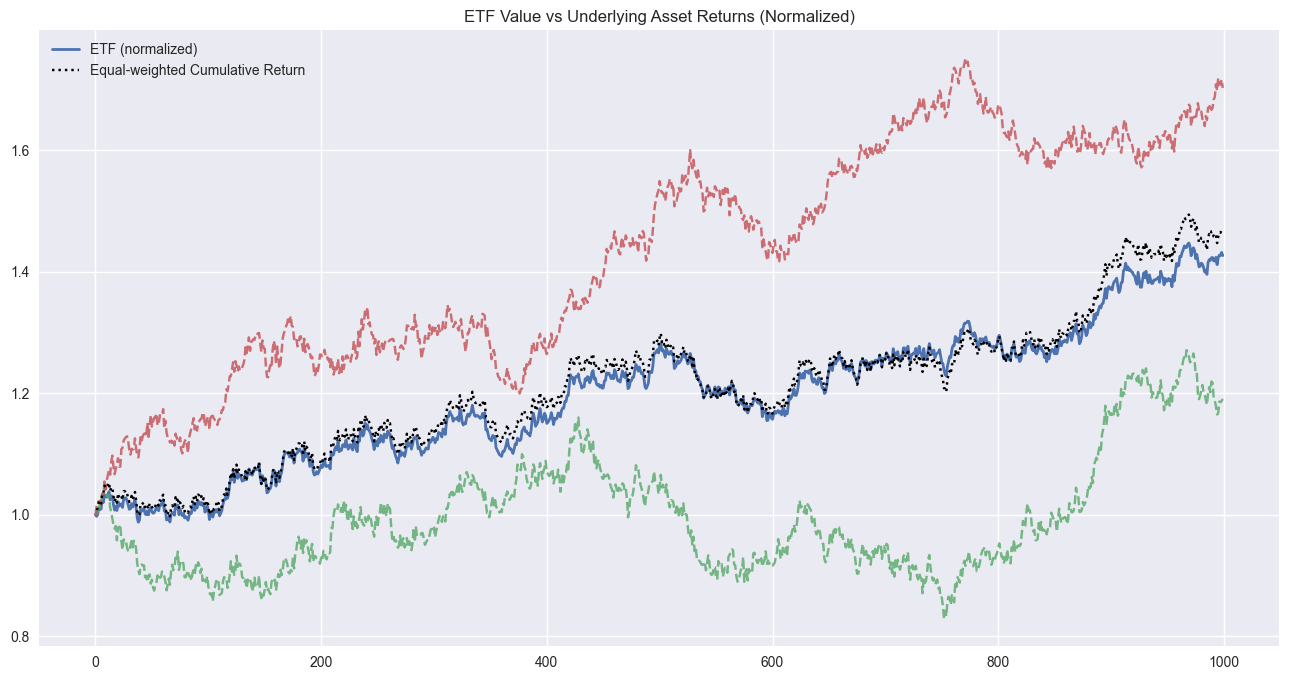

In [13]:
returns = np.diff(np.log(p), axis=1)

# ETF normalized
plt.figure(figsize=(16,8))
plt.plot(K / K[0], label='ETF (normalized)', linewidth=2)

# Underlying assets normalized
plt.plot((p / p[:, [0]]).T, '--', alpha=0.8)

# Equal-weighted cumulative return portfolio
p_df = pd.DataFrame(p.T)
equal_weight = (1 + p_df.pct_change().mean(axis=1)).cumprod()
plt.plot(equal_weight, label='Equal-weighted Cumulative Return', color='black', linestyle=':')

plt.legend()
plt.title('ETF Value vs Underlying Asset Returns (Normalized)')
plt.grid(True)
plt.show()

In [14]:
###
def pca_weights(V, riskDist=None, riskTarget=1.0):
    eigvals, eigvecs = np.linalg.eigh(V)           # eigenvalues ascending
    idx = np.argsort(eigvals)[::-1]                # descending
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
    N = len(eigvals)
    if riskDist is None:
        riskDist = np.zeros(N); riskDist[-1] = 1.0
    riskDist = np.array(riskDist, dtype=float); riskDist /= riskDist.sum()
    beta = np.sqrt(riskTarget * riskDist / eigvals)   # beta ∝ sqrt(R / lambda)
    w = eigvecs @ beta
    # rescale so portfolio volatility equals riskTarget
    sigma = np.sqrt(w.T @ V @ w)
    w = w * (riskTarget / sigma)
    return w

In [15]:
V = np.array([
    [0.10, 0.08, 0.06],
    [0.08, 0.10, 0.08],
    [0.06, 0.08, 0.10]
])
w = pca_weights(V, riskDist=[0.5, 0.3, 0.2], riskTarget=1.0)
w

array([-1.03945147, -3.98183144,  2.83353187])

In [16]:
###
def getEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0.0, 0.0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sPos > h: sPos = 0; tEvents.append(i)
        elif sNeg < -h: sNeg = 0; tEvents.append(i)
    return tEvents

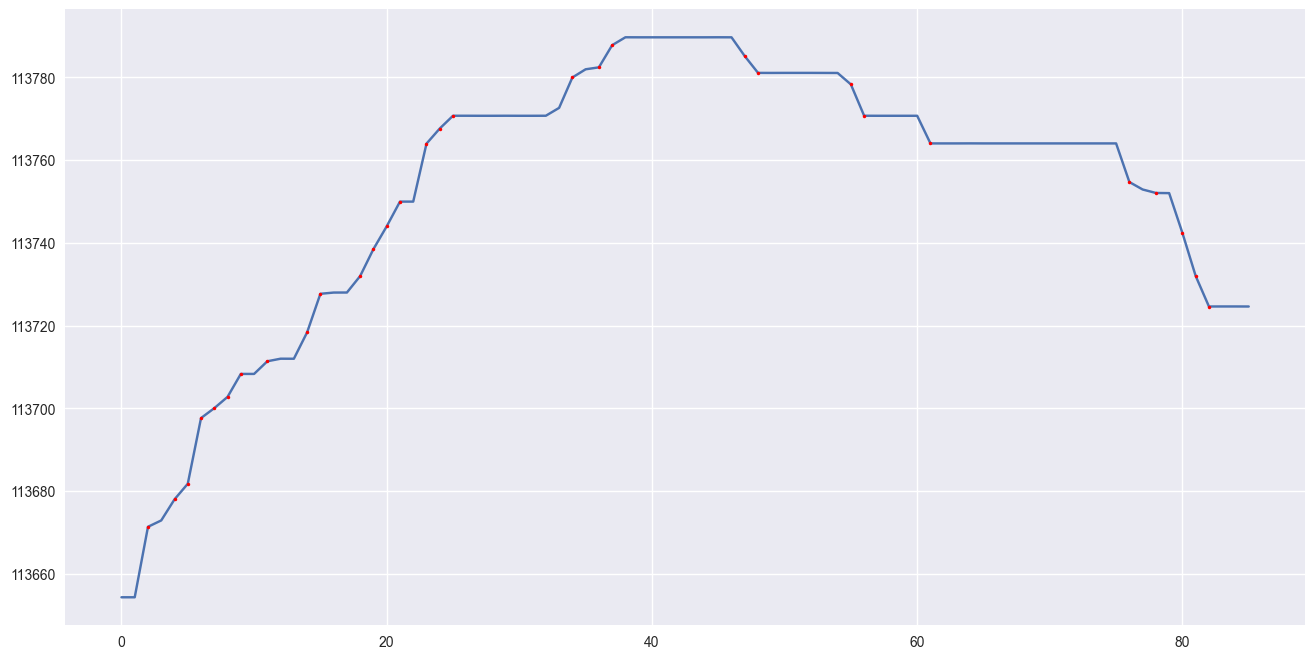

In [18]:
gRaw = pd.read_csv('../data/btcusdt/2025102617_tradebars.csv')['close']
h = 2
output = getEvents(gRaw, h)
plt.figure(figsize=(16,8))
plt.plot(gRaw)
plt.plot(gRaw[output], 'ro', markersize=2.5);